In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import random
#import pyproj
#import shapely.geometry
from tqdm.notebook import tqdm
from math import sin, cos, sqrt, atan2, radians

from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)

In [2]:
# Set the size bins
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,330]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [3]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['impact_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

,high,low,lambda_start,lambda_end,impact_factor
005,16950000,1695000,1.0,2,0.1
005-009,855000,85500,1.1,4,0.2
010-050,146100,14610,1.2,8,0.3
050-100,8700,870,1.4,16,0.6
100+,3050,305,1.8,32,0.8


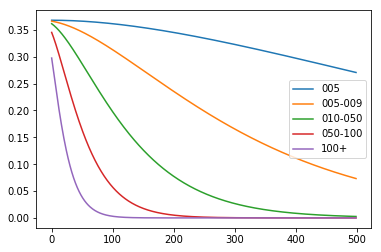

total impacts 2875337.0
impacts by diameter {'005': 2507102.0, '005-009': 225438.0, '010-050': 139204.0, '050-100': 2669.0, '100+': 924.0}
fraction of total {'005': 0.87, '005-009': 0.08, '010-050': 0.05, '050-100': 0.0, '100+': 0.0}


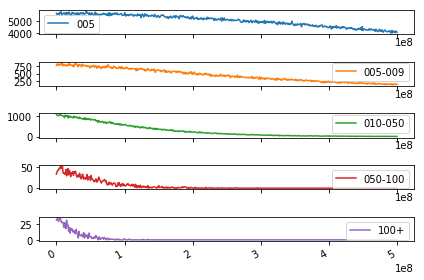

,high,low,lambda_start,lambda_end,impact_factor,total
005,16950000,1695000,1.0,2,0.000066,2507102.0
005-009,855000,85500,1.1,4,0.000463,225438.0
010-050,146100,14610,1.2,8,0.000348,139204.0
050-100,8700,870,1.4,16,0.007796,2669.0
100+,3050,305,1.8,32,0.008292,924.0


In [4]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'impact_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'impact_factor'] = df_freq.loc[d,'impact_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'impact_factor'] = df_freq.loc[d,'impact_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total)
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [5]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [22]:
def IMPAaCS(fw_state, z_layers):
    """
    This is the critical component of this model
    This function will change the chemical makeup of each grid cell
        according to the chemical theory put forward by Faltys-Wielicki [2021]
    """
    
    #####      DYNAMIC FACTORS       #############################
    TSiO2 = random.uniform(62.58, 64.9)
    GSiO2 = random.uniform(68.71, 68.15)
    change = TSiO2/GSiO2
    wtchange = GSiO2-TSiO2
    GRANOPHYRE_up = random.uniform(1/2, 3/4)
    GRANOPHYRE_lo = 1-GRANOPHYRE_up
    
    #####      DO THE DYANMICS       #############################
    for i in range(int(np.ceil(z_layers/3))):
        fw_state['sio2'][i] = fw_state['sio2'][i] * change
        fw_state['vol'][i] = fw_state['vol'][i] + wtchange
        fw_state['gran'][i] = fw_state['gran'][i] * GRANOPHYRE_up
    for i in range(int(np.ceil(z_layers/3))+1,z_layers):
        fw_state['gran'][i] = fw_state['gran'][i] * GRANOPHYRE_lo
    
    return fw_state

In [ ]:
grid_cell_state = {}
z_discretized_km = int(5)

# Loop through impacts, the df has them stored by time and diameter bn
for it, t in tqdm(enumerate(df.index.values)):
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):
            
            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            
            # Specify the diameter within the bin
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
            z_layers = int(np.ceil(impactor_diameter/z_discretized_km))
            
            # The impact crator is 10*Diameter, so the radius is half that
            crator_diameter = 10*impactor_diameter
            crator_radius = crator_diameter/2
            
            # Find the grid
            impacted_grid_cells = []
            for ilon in egrid.londim:
                for ilat in egrid.latdim:
                    D = distance(impact_lat,ilat,impact_lon,ilon)
                    if D < crator_radius:
                        impacted_grid_cells.append([ilon, ilat])
                        
            # The grid size is 25KM, but the smallest impact is 5KM
            # So if the impactor is smaller than the grid
            # the impact should have a D^2/G^2 change of affecting the chemistry
            # So this means that the grid is just a sample of earth
            # for computational efficiency
            for grid_cell in impacted_grid_cells:
                grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

                ##### Set the initial state values
                #####     REPLACE WITH SOME REAL ESTIMATE OF INITIAL VALUES     ########
                if grid_cell_id not in grid_cell_state.keys():
                    grid_cell_state[grid_cell_id] = {'sio2':np.ones(z_layers)*40, 
                                                     'vol':np.ones(z_layers)*40,
                                                     'gran':np.ones(z_layers)*100}
                else: # If there is an existing state key, 
                      # and the current impact depth is larger than the z layers, 
                      # then extend the z layers
                    existing_z_layers = grid_cell_state[grid_cell_id]['sio2'].shape[0]
                    if z_layers > existing_z_layers:
                        grid_cell_state[grid_cell_id]['sio2'] = np.append(grid_cell_state[grid_cell_id]['sio2'], 
                                                                np.ones(z_layers - existing_z_layers)*40)
                        grid_cell_state[grid_cell_id]['vol'] = np.append(grid_cell_state[grid_cell_id]['vol'], 
                                                               np.ones(z_layers - existing_z_layers)*40)
                        grid_cell_state[grid_cell_id]['gran'] = np.append(grid_cell_state[grid_cell_id]['vol'], 
                                                               np.ones(z_layers - existing_z_layers)*100)
                ################      DO THE DYANMICS       #############################
                grid_cell_state[grid_cell_id] = IMPAaCS(grid_cell_state[grid_cell_id], z_layers)

                ##### Testing one cell:
                if grid_cell_id == list(grid_cell_state.keys())[0]:
                    print(grid_cell_state[list(grid_cell_state.keys())[0]])
                
        
    if it > 10:
        break


|          | 0/? [00:00<?, ?it/s]

{'sio2': array([37.20282645, 37.20282645, 37.20282645, 37.20282645, 40.        ,
       40.        , 40.        , 40.        , 40.        , 40.        ,
       40.        ]), 'vol': array([44.7689594, 44.7689594, 44.7689594, 44.7689594, 40.       ,
       40.       , 40.       , 40.       , 40.       , 40.       ,
       40.       ]), 'gran': array([ 65.93546876,  65.93546876,  65.93546876,  65.93546876,
       100.        ,  34.06453124,  34.06453124,  34.06453124,
        34.06453124,  34.06453124,  34.06453124])}
{'sio2': array([34.79792702, 34.79792702, 34.79792702, 34.79792702, 37.4142831 ,
       37.4142831 , 37.4142831 , 37.4142831 , 37.4142831 , 37.4142831 ,
       37.4142831 , 37.4142831 , 37.4142831 , 37.4142831 , 37.4142831 ,
       37.4142831 , 37.4142831 , 37.4142831 , 37.4142831 , 37.4142831 ,
       37.4142831 , 37.4142831 , 40.        , 40.        , 40.        ,
       40.        , 40.        , 40.        , 40.        , 40.        ,
       40.        , 40.        , 40. 

In [17]:
np.ceil(z_layers/3)

4.0